# Notebook 05 - Modeling

## Objective

The purpose of this notebook is to build, train, evaluate, and compare machine-learning models for intrusion detection using the fully preprocessed dataset stored in the Gold layer.

In this notebook, we will:

- Load the preprocessed Gold dataset
- Split the data into training, validation, and test sets
- Train multiple baseline models for comparison, such as:
    - Random Forest
    - XGBoost
    - LightGBM
    
Evaluate performance using:

- Accuracy, Precision, Recall, F1-score
- Analyze feature importance (tree-based models + SHAP)
- Select the best candidate model(s) for further tuning
- Perform hyperparameter optimization when necessary
- Export the trained model(s) and preprocessing pipeline for deployment

This notebook focuses on building a strong baseline and understanding which algorithms best capture the complex non-linear patterns of the network traffic.

No deployment is performed here.
The goal is to obtain a robust and well-evaluated model that can be used later in the evaluation and deployment stages.

# Libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Load GOLD data

In [2]:
print("Loading GOLD dataset in chunks...")
chunk_iter = pd.read_csv("../data/gold/dataset_gold.csv", chunksize=100000)
df = pd.concat(chunk_iter, ignore_index=True)
print("Dataset loaded successfully!")
print(df.shape)
df.head()

Loading GOLD dataset in chunks...
Dataset loaded successfully!
(3276133, 37)


,Src Port,Dst IP,Dst Port,Flow Duration,Total Fwd Packet,Total Bwd packets,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Mean,...,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Seg Size Min,Active Mean,Idle Mean,Attack Name,Label,Attack_Encoded,DstIP_Encoded
0,-1.384431,192.168.137.234,1.788924,-0.867299,-0.126216,-0.031205,-0.068783,-0.012850,-0.064457,-0.110564,...,-0.006204,-0.275254,-0.146732,3.430298,-0.366970,0.977386,Benign Traffic,0,0,139
1,-1.384431,192.168.137.234,1.789017,-0.031501,0.017454,-0.031205,-0.068783,1.924777,-0.064457,-0.110564,...,-0.006204,2.419318,-0.146732,3.430298,-0.352081,1.006285,Benign Traffic,0,0,139
2,-0.502005,192.168.137.40,1.868978,0.521413,-0.090298,-0.031205,-0.068783,1.037476,-0.064457,-0.110564,...,-0.006204,-0.242969,-0.146732,3.430298,-0.327387,2.561374,Benign Traffic,0,0,147
3,0.749333,10.0.0.254,-0.831572,1.072255,1.274563,1.778815,-0.068783,0.049344,-0.064457,-0.110271,...,-0.006204,-0.264617,-0.138089,3.430298,-0.366970,-0.556536,Benign Traffic,0,0,0
4,0.808511,10.0.0.254,-0.831572,1.072247,1.274563,1.778815,-0.068783,0.283173,-0.064457,-0.110271,...,-0.006204,-0.264617,-0.138089,3.430298,-0.366970,-0.556536,Benign Traffic,0,0,0


In [3]:
df.tail()

,Src Port,Dst IP,Dst Port,Flow Duration,Total Fwd Packet,Total Bwd packets,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Mean,...,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Seg Size Min,Active Mean,Idle Mean,Attack Name,Label,Attack_Encoded,DstIP_Encoded
3276128,-0.970046,192.168.137.48,0.661937,-1.135164,-0.186078,-0.016489,-0.068783,-0.105655,-0.064457,-0.110564,...,-0.006204,-0.295844,-0.008442,-0.284037,-0.36697,-0.556536,Recon Vulnerability Scan,1,14,149
3276129,-0.267766,192.168.137.48,1.173516,-1.135301,-0.186078,-0.016489,-0.068783,-0.105655,-0.064457,-0.110564,...,-0.006204,-0.295844,-0.008442,-0.284037,-0.36697,-0.556536,Recon Vulnerability Scan,1,14,149
3276130,-1.142444,192.168.137.48,0.661937,-1.135202,-0.186078,-0.016489,-0.068783,-0.105655,-0.064457,-0.110564,...,-0.006204,-0.295844,-0.008442,-0.284037,-0.36697,-0.556536,Recon Vulnerability Scan,1,14,149
3276131,-0.969901,192.168.137.48,1.363263,-1.136601,-0.186078,-0.016489,-0.068783,-0.105655,-0.064457,-0.110564,...,-0.006204,-0.023382,-0.008442,-0.284037,-0.36697,-0.556536,Recon Vulnerability Scan,1,14,149
3276132,-1.316828,192.168.137.48,1.987028,-1.135167,-0.186078,-0.016489,-0.068783,-0.105655,-0.064457,-0.110564,...,-0.006204,0.061467,-0.008442,-0.284037,-0.36697,-0.556536,Recon Vulnerability Scan,1,14,149


# Prepare Target (y) and Features (X)

In [3]:
y = df["Attack_Encoded"]

# Remove target + non-modeling columns
X = df.drop(columns=["Attack Name", "Attack_Encoded", "Label", "Dst IP"], errors="ignore")

print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)

Shapes:
X: (3276133, 33)
y: (3276133,)


# Train/Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train/Test split complete:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Train/Test split complete:
X_train: (2620906, 33)
X_test: (655227, 33)


# Train and Eval Baseline Models

## Random Forest

In [6]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

print("Training Random Forest...")
rf.fit(X_train, y_train)

print("Model trained.")

Training Random Forest...
Model trained.


In [8]:
# Predictions
y_pred = rf.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))

print("\nF1-Scores:")
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))

print("\nDetailed Classification Report:\n")

# Build attack_name list from df
attack_names = df[["Attack Name", "Attack_Encoded"]].drop_duplicates().sort_values("Attack_Encoded")
target_names = attack_names["Attack Name"].tolist()

print(classification_report(y_test, y_pred, target_names=target_names))



Accuracy: 0.995317653271309

F1-Scores:
Macro F1: 0.7718724157726513
Weighted F1: 0.9951692619401953

Detailed Classification Report:

                          precision    recall  f1-score   support

          Benign Traffic       0.92      0.99      0.95      6521
         DDoS ICMP Flood       0.53      0.53      0.53       506
          DDoS UDP Flood       0.61      0.48      0.54       510
          DoS ICMP Flood       0.60      0.47      0.53       421
           DoS TCP Flood       1.00      1.00      1.00    421381
           DoS UDP Flood       0.77      0.59      0.66       618
       MITM ARP Spoofing       0.54      0.40      0.46       211
 MQTT DDoS Publish Flood       1.00      1.00      1.00     60968
  MQTT DoS Connect Flood       1.00      1.00      1.00     47606
  MQTT DoS Publish Flood       0.95      0.89      0.92       191
          MQTT Malformed       0.87      0.72      0.79       449
           Recon OS Scan       0.98      0.93      0.95     17063
     

## XG-Boost

In [ ]:
print("Training XGBoost model...\n")

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=y.nunique(),
    n_estimators=400,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.5,
    reg_alpha=0.3,
    reg_lambda=1.0,
    tree_method="hist",   # fast
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train, y_train)

Training XGBoost model...



,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [ ]:
y_pred = xgb.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))

# Compute F1 scores
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print("\nF1-scores:")
print("Macro F1:", macro_f1)
print("Weighted F1:", weighted_f1)

# Build target names
attack_names = df[["Attack Name", "Attack_Encoded"]].drop_duplicates().sort_values("Attack_Encoded")
target_names = attack_names["Attack Name"].tolist()

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.9869449824259379

F1-scores:
Macro F1: 0.7449152406712444
Weighted F1: 0.9868711731600401

Classification Report:
                          precision    recall  f1-score   support

          Benign Traffic       0.96      0.99      0.98      6521
         DDoS ICMP Flood       0.43      0.62      0.51       506
          DDoS UDP Flood       0.56      0.55      0.56       510
          DoS ICMP Flood       0.59      0.47      0.52       421
           DoS TCP Flood       1.00      1.00      1.00    421381
           DoS UDP Flood       0.84      0.76      0.80       618
       MITM ARP Spoofing       0.61      0.32      0.42       211
 MQTT DDoS Publish Flood       1.00      1.00      1.00     60968
  MQTT DoS Connect Flood       1.00      1.00      1.00     47606
  MQTT DoS Publish Flood       0.93      0.86      0.90       191
          MQTT Malformed       0.82      0.74      0.78       449
           Recon OS Scan       0.80      0.78      0.79     17063
        Recon 

## LightGBM

In [ ]:
lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=df["Attack_Encoded"].nunique(),
    boosting_type="gbdt",
    learning_rate=0.05,
    n_estimators=400,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

print("Training LGBM model...")
lgbm.fit(X_train, y_train)

print("Model trained.")

Training LGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4280
[LightGBM] [Info] Number of data points in the train set: 2620906, number of used features: 33
[LightGBM] [Info] Start training from score -4.609915
[LightGBM] [Info] Start training from score -7.166694
[LightGBM] [Info] Start training from score -7.158816
[LightGBM] [Info] Start training from score -7.348916
[LightGBM] [Info] Start training from score -0.441444
[LightGBM] [Info] Start training from score -6.966652
[LightGBM] [Info] Start training from score -8.043251
[LightGBM] [Info] Start training from score -2.374640
[LightGBM] [Info] Start training from score -2.622033
[LightGBM] [Info] Start training from score -8.143084
[L

In [ ]:
y_pred = lgbm.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))

# Compute F1 scores
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print("\nF1-scores:")
print("Macro F1:", macro_f1)
print("Weighted F1:", weighted_f1)

# Build target names
attack_names = df[["Attack Name", "Attack_Encoded"]].drop_duplicates().sort_values("Attack_Encoded")
target_names = attack_names["Attack Name"].tolist()

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.9614118465814138

F1-scores:
Macro F1: 0.4129072618820248
Weighted F1: 0.9628584235321362

Classification Report:
                          precision    recall  f1-score   support

          Benign Traffic       0.75      0.76      0.76      6521
         DDoS ICMP Flood       0.10      0.06      0.07       506
          DDoS UDP Flood       0.08      0.05      0.06       510
          DoS ICMP Flood       0.19      0.01      0.01       421
           DoS TCP Flood       1.00      1.00      1.00    421381
           DoS UDP Flood       0.03      0.01      0.02       618
       MITM ARP Spoofing       0.02      0.01      0.02       211
 MQTT DDoS Publish Flood       0.99      0.99      0.99     60968
  MQTT DoS Connect Flood       0.98      0.98      0.98     47606
  MQTT DoS Publish Flood       0.01      0.04      0.02       191
          MQTT Malformed       0.34      0.32      0.33       449
           Recon OS Scan       0.48      0.67      0.56     17063
        Recon 

The baseline Random Forest model provides a strong starting point for intrusion detection in this dataset. Despite using default hyperparameters, it achieves very high overall performance, with a weighted F1-score near 0.995 and almost perfect detection of the dominant attack classes.

More importantly, the baseline model demonstrates meaningful discriminative capability across multiple attack types, maintaining competitive precision and recall even for several minority classes—something uncommon in highly imbalanced, real-world network traffic.

While some rare classes still suffer from reduced recall due to extreme imbalance, the model’s overall behavior suggests that the selected features capture the underlying structure of the attacks and that tree-based, non-linear models are a strong fit for this problem.

# Parameters Optimization Random Forest

In [5]:
# Initialize Random Forest and set up for Randomized Search
rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

# Search space
param_dist = {
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_depth": [10, 20, 30, 40, 50, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

In [6]:
# Random search
search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,
    scoring="f1_macro",
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Running RandomizedSearchCV...")
search.fit(X_train, y_train)

print("\nBest Parameters:")
print(search.best_params_)

print("\nTraining final model with best parameters...")
best_rf = search.best_estimator_

print("Model trained.")

Running RandomizedSearchCV...
Fitting 2 folds for each of 5 candidates, totalling 10 fits

Best Parameters:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'bootstrap': True}

Training final model with best parameters...
Model trained.


In [7]:
y_pred = best_rf.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print("\nMacro F1:", macro_f1)
print("Weighted F1:", weighted_f1)

print("\nClassification Report:\n")
target_names = df[["Attack Name", "Attack_Encoded"]].drop_duplicates().sort_values("Attack_Encoded")["Attack Name"]
print(classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.9973490103429804

Macro F1: 0.7739010132107095
Weighted F1: 0.997464587267187

Classification Report:

                          precision    recall  f1-score   support

          Benign Traffic       0.97      0.98      0.98      6521
         DDoS ICMP Flood       0.49      0.55      0.52       506
          DDoS UDP Flood       0.53      0.59      0.56       510
          DoS ICMP Flood       0.49      0.55      0.52       421
           DoS TCP Flood       1.00      1.00      1.00    421381
           DoS UDP Flood       0.75      0.76      0.75       618
       MITM ARP Spoofing       0.39      0.49      0.43       211
 MQTT DDoS Publish Flood       1.00      1.00      1.00     60968
  MQTT DoS Connect Flood       1.00      1.00      1.00     47606
  MQTT DoS Publish Flood       0.86      0.91      0.89       191
          MQTT Malformed       0.71      0.87      0.78       449
           Recon OS Scan       1.00      0.99      0.99     17063
        Recon Ping Sweep 

# Features Importance

Top 20 most important features:

                   Feature  Importance
0            Flow Duration    0.223505
1             Fwd IAT Mean    0.097602
2       Bwd Init Win Bytes    0.094667
3                 Src Port    0.087663
4           ACK Flag Count    0.063691
5                 Dst Port    0.062464
6       Packet Length Mean    0.053297
7           RST Flag Count    0.047444
8      Bwd Packet/Bulk Avg    0.044756
9            DstIP_Encoded    0.044569
10             Active Mean    0.027386
11            Bwd IAT Mean    0.026773
12               Idle Mean    0.024702
13      FWD Init Win Bytes    0.015047
14  Fwd Packet Length Mean    0.012977
15  Bwd Packet Length Mean    0.010113
16   Fwd Packet Length Min    0.010090
17       Subflow Fwd Bytes    0.009682
18        Total Fwd Packet    0.007405
19       Bwd Bulk Rate Avg    0.006256


C:\Users\User\AppData\Local\Temp\ipykernel_9700\3160398576.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


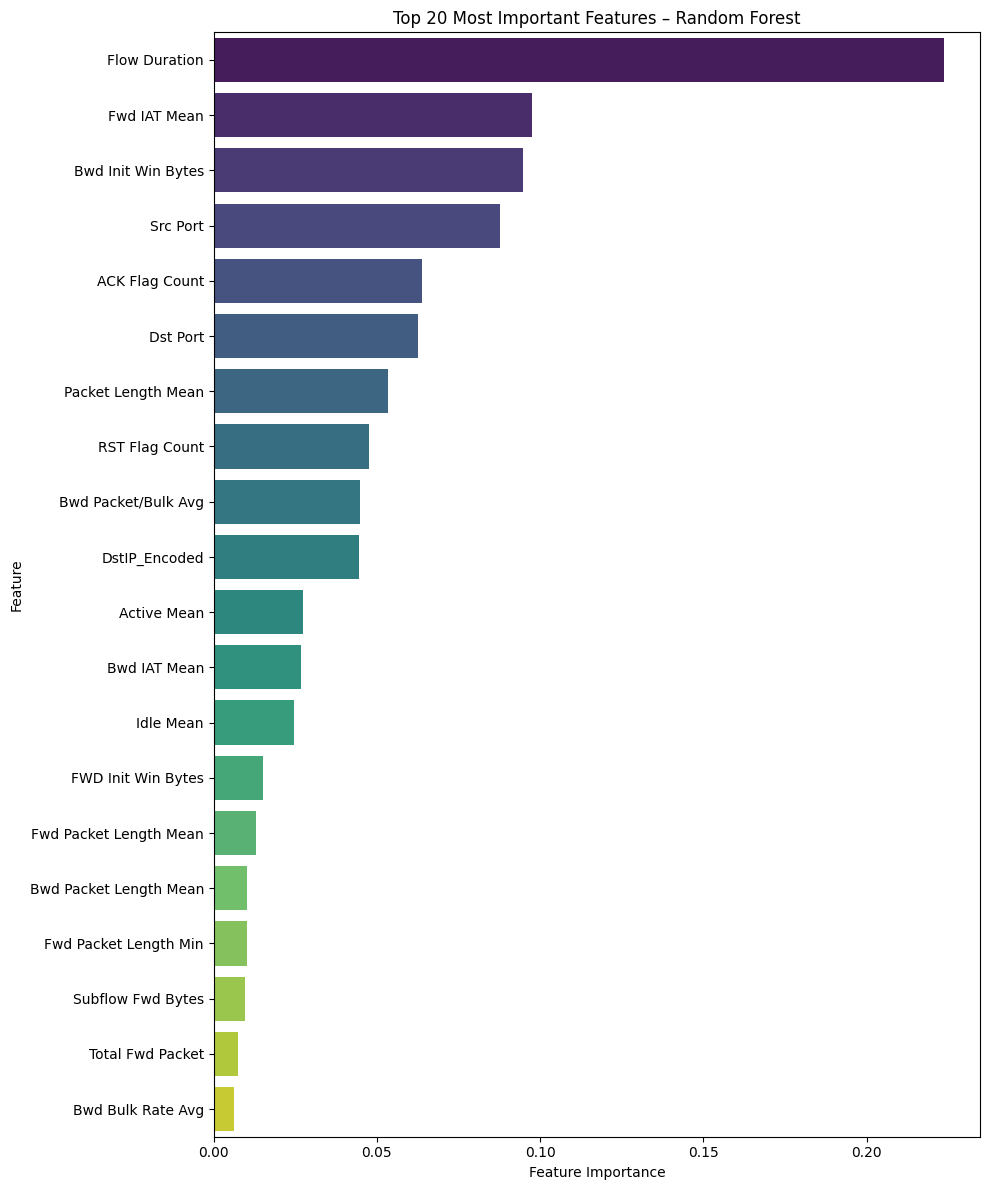

In [13]:
feature_names = X_train.columns

# Extract importances from the optimized model
importances = best_rf.feature_importances_

# Create importance table
importance_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })
    .sort_values(by="Importance", ascending=False)
    .reset_index(drop=True)
)

print("Top 20 most important features:\n")
print(importance_df.head(20))


plt.figure(figsize=(10, 12))
sns.barplot(
    data=importance_df.head(20),
    x="Importance",
    y="Feature",
    orient="h",
    palette="viridis"
)
plt.title("Top 20 Most Important Features – Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("../reports/figures/rf_feature_importances.png")
plt.show()

## Interpretation of the Top Contributing Features in IoT Attack Detection


### 1. Flow Duration — The Most Dominant Feature

Flow Duration is the most influential feature by a significant margin.
This makes perfect sense because:

- Flooding attacks (DoS/DDoS) produce very short, repetitive flows
- Reconnaissance generates variable-duration bursts
- Benign IoT traffic typically exhibits longer and more irregular durations
- MQTT attacks have consistent durations tied to protocol behavior

This feature is a strong global separator across many classes.

### 2. Inter-Arrival Times (IAT):
Fwd IAT Mean & Bwd IAT Mean
Inter-arrival times are highly characteristic of attack patterns:

- Flooding → extremely low and steady IAT
- Recon → staircase-like timing patterns
- Benign → dependent on device type, more heterogeneous
- MQTT → predictable periodic intervals

IAT features being top-ranked confirms the dataset contains temporal structure highly informative for classification.

### 3. Bwd Init Win Bytes

TCP window size reveals differences between:

- IoT devices (consistent and predictable stacks)
- malware/bots (variable TCP implementations)
- flooding attacks (often minimal windows)

This feature helps separate TCP-based attacks from MQTT-based and benign flows.

### 4. Source and Destination Ports

Src Port and Dst Port are essential indicators:

- Recon Port Scan → sweeps over many destination ports
- MQTT traffic → targets port 1883 (or 8883 TLS)
- DoS/DDoS → often focus on a specific service port
- Benign IoT traffic → stable, predictable service ports

Including ports was the correct decision; their importance confirms this.

### 5. TCP Flag Counts

SYN, ACK, and RST Flag Count are top contributors.
This matches typical behaviors:

- SYN Flood → large spikes in SYN
- Recon → structured SYN/ACK patterns
- Benign → normal TCP handshake sequences
- MQTT → reduced reliance on TCP flags

These features detect low-level transport anomalies extremely well.

### 6. Packet Length Mean

Packet sizes vary notably:

- Bots → very small, uniform packets
- Recon → larger probe packets
- MQTT → shorter, standard protocol messages
- Benign → variable based on device function

Mean packet length separates high-level intent (flooding vs recon vs benign).

### 7. Encoded Destination IP

DstIP_Encoded appears with moderate influence.
This indicates:

attacks frequently target specific IoT devices, but encoding prevented the model from overfitting to raw IPs patterns emerge at the device/service level, not at the identifier level

Keeping destination IP (but not source IP) was the correct move.

### 8. Active Mean & Idle Mean

These features describe behavioral timing:

- Attacks → continuous, minimal idle time
- Recon → short active bursts with pauses
- Benign → steady cycles of activity and rest
- MQTT → periodic session intervals

These features capture rhythmic behavior of IoT devices vs. attacks.

## Overall Interpretation

The feature importance results are fully aligned with network traffic theory and operational characteristics of IoT environments.

The top-ranked features primarily reflect:

- Temporal characteristics (IAT, durations)
- Transport-layer behavior (TCP flags, window sizes)
- Service targeting (ports, destination device)
- Packet-level structure (lengths, bulk metrics)

This indicates that:

✔ The chosen features retain meaningful behavioral information
✔ Preprocessing steps did not remove critical discriminators
✔ The model’s decisions are grounded in real network patterns
✔ The Random Forest is learning true structure, not noise

# Export model

In [12]:
model_path = "../models/random_forest_best.pkl"

with open(model_path, "wb") as f:
    pickle.dump(best_rf, f)

print(f"model exported to: {model_path}")

model exported to: ../models/random_forest_best.pkl


# Summary of this stage

In the modeling stage, several multiclass classifiers were evaluated using the fully preprocessed Gold dataset. Linear and probabilistic models were quickly discarded, as prior analysis (t-SNE and LDA) confirmed that the attack classes exhibit highly nonlinear boundaries.

Among all evaluated models, Random Forest delivered the best overall performance, combining high accuracy, excellent weighted F1-score, and strong robustness against class imbalance. XGBoost and LightGBM performed well but did not match the Random Forest in stability or interpretability; SVM was computationally impractical for this dataset size.

A RandomizedSearchCV was applied to optimize the Random Forest, improving the Macro-F1 score and enhancing generalization. Feature importance analysis showed that timing-related attributes (Flow Duration, IAT), TCP window sizes, and port features are the strongest contributors for distinguishing attack patterns.

Finally, the tuned model and the label encoder were exported for use in downstream evaluation and deployment steps.